In [ ]:
## Chapter04から使用するテキストデータをコピーする（事前にChapter04/Sentiment.ipynbを実行してください）
!cp -r ../Chapter04/text ./
!cp -r ../Chapter04/sisyou_db ./

In [2]:
import spacy
from spacy.matcher import Matcher
import pandas as pd
import collections

nlp = spacy.load("ja_ginza")
matcher = Matcher(nlp.vocab)


In [3]:
def extract_words(sent, pos_tags, stopwords):
    words = [token.lemma_ for token in sent
             if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def count_cooccurrence(tokens):    
    count_model = CountVectorizer(ngram_range=(1,1)) # default unigram model
    X = count_model.fit_transform(tokens)
    words = count_model.get_feature_names()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)

    X[X > 0] = 1 # limit to 1 occurrence in a document.
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    return words, word_counts, Xc, X

In [8]:
def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [(word, {'weight': count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc):
    Xc_max = Xc.max()
    cutoff = 0.01 * Xc_max
    weights = [(words[i], words[j], Xc[i,j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

In [9]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt

def create_network(words, word_counts, Xc):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    # pyvis_G.from_nx(G) # pyvisライブラリ現状では，属性が反映されない．
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

In [6]:
input_fn = "text/kageotoko.corpus.txt"
with open(input_fn) as f:
    text = f.read()

include_pos = ('PROPN')
stopwords = ()

doc = nlp(text)
sents = [' '.join(extract_words(sent, include_pos, stopwords))
          for sent in doc.sents]
words, word_counts, Xc, X = count_cooccurrence(sents)

/Users/tksakaki/.pyenv/versions/3.9.5/envs/ginza4.0/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


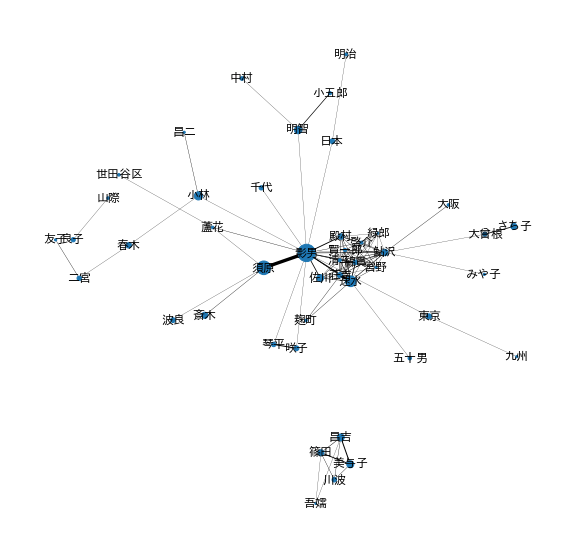

In [10]:
G = create_network(words, word_counts, Xc)
pyplot_network(G)
pyvis_G = nx2pyvis_G(G)
pyvis_G.show("mygraph.html")

In [12]:
patterns = [[{"POS": "NOUN"}] * n for n in [2,3,4]]
patterns.extend([[{"POS": "PROPN"}] * n for n in [2,3,4]])
patterns.append([{"POS": "NOUN"},{"POS": "PROPN"}])
patterns.append([{"POS": "NOUN"},{"POS": "PROPN"},{"POS": "PROPN"}])
patterns.append([{"POS": "PROPN"},{"POS": "NOUN"}])
patterns.append([{"POS": "PROPN"},{"POS": "NOUN"},{"POS": "NOUN"}])
## GiNZA 5.0.X
#for pattern in patterns:
#    name = f'noun_phrase_{len(pattern)}'
#    matcher.add(name, [pattern])

# GiNZA 4.0.X
for pattern in patterns:
    name = f'propn_{len(pattern)}'
    matcher.add(name, None, pattern)

In [13]:
input_fn = "text/kageotoko.corpus.txt"

with open(input_fn) as f:
    text = f.read()

In [14]:
counter = collections.Counter()
for doc in nlp.pipe([text]):
    nps = [doc[begin:end].text for _, begin, end in matcher(doc)]
    counter.update(nps)

In [15]:
with open("characters_raw.txt","w") as fout:
    for word, count in counter.most_common(200):
        fout.write("{}\n".format(word))

## 辞書のシーズとなる人名リストを作成
* cp characters_raw.txt characters.txt
* characters.txt を目視でチェックして、人名のみを残す

In [16]:
## sudachipy用の辞書ファイルを作成

file_character = "characters.txt"
file_dic = "dic_characters.txt"


with open(file_dic,"w") as fout:
     for word in open(file_character):
          word = word.rstrip()
          fout.write("{},4789,4789,5000,{},名詞,固有名詞,一般,*,*,*,*,{},*,*,*,*,*\n".format(word,word,word))
          print("{},4789,4789,5000,{},名詞,固有名詞,一般,*,*,*,*,{},*,*,*,*,*".format(word,word,word))

良斎,4789,4789,5000,良斎,名詞,固有名詞,一般,*,*,*,*,良斎,*,*,*,*,*
じいさん,4789,4789,5000,じいさん,名詞,固有名詞,一般,*,*,*,*,じいさん,*,*,*,*,*
速水さん,4789,4789,5000,速水さん,名詞,固有名詞,一般,*,*,*,*,速水さん,*,*,*,*,*
佐川春泥,4789,4789,5000,佐川春泥,名詞,固有名詞,一般,*,*,*,*,佐川春泥,*,*,*,*,*
速水荘吉,4789,4789,5000,速水荘吉,名詞,固有名詞,一般,*,*,*,*,速水荘吉,*,*,*,*,*
毛利氏,4789,4789,5000,毛利氏,名詞,固有名詞,一般,*,*,*,*,毛利氏,*,*,*,*,*
だんなさま,4789,4789,5000,だんなさま,名詞,固有名詞,一般,*,*,*,*,だんなさま,*,*,*,*,*
Ｘ氏,4789,4789,5000,Ｘ氏,名詞,固有名詞,一般,*,*,*,*,Ｘ氏,*,*,*,*,*
川波良斎,4789,4789,5000,川波良斎,名詞,固有名詞,一般,*,*,*,*,川波良斎,*,*,*,*,*
春木夫人,4789,4789,5000,春木夫人,名詞,固有名詞,一般,*,*,*,*,春木夫人,*,*,*,*,*
ぼろ男,4789,4789,5000,ぼろ男,名詞,固有名詞,一般,*,*,*,*,ぼろ男,*,*,*,*,*
おかた,4789,4789,5000,おかた,名詞,固有名詞,一般,*,*,*,*,おかた,*,*,*,*,*
琴平咲子,4789,4789,5000,琴平咲子,名詞,固有名詞,一般,*,*,*,*,琴平咲子,*,*,*,*,*
気ちがい良斎,4789,4789,5000,気ちがい良斎,名詞,固有名詞,一般,*,*,*,*,気ちがい良斎,*,*,*,*,*
明智さん,4789,4789,5000,明智さん,名詞,固有名詞,一般,*,*,*,*,明智さん,*,*,*,*,*
お金持ち,4789,4789,5000,お金持ち,名詞,固有名詞,一般,*,*,*,*,お金持ち,*,*,*,*,*
婦人たち,4789,4789,5000,婦人たち,名詞,固有名詞,一般,*,*,*,*,婦人たち,*,*,*,*,*
覆面婦人,4789

In [37]:
## ユーザ辞書(user.dic)の生成
!sudachipy ubuild -s ~/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sudachidict_core/resources/system.dic  dic_characters.txt

reading the source file...46 words
writing the POS table...2 bytes
writing the connection matrix...4 bytes
building the trie...done
writing the trie...3076 bytes
writing the word-ID table...234 bytes
writing the word parameters...280 bytes
writing the word_infos...1126 bytes
writing word_info offsets...184 bytes


## sudachi.jsonを編集
!vi  ~/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sudachipy/resources/sudachi.json 
```
"characterDefinitionFile" : "char.def",
"userDict" : ["/content/user.dic"],      ← ユーザー辞書ファイルのパスを指定
```

In [17]:
text = "「このかた、千代ちゃんていうのよ。川波良斎、ご存じでしょう。あすこの小間使いなの。"

nlp = spacy.load("ja_ginza")
doc = nlp(text)
for token in doc:
    print(token,token.pos_,token.lemma_)


「 PUNCT 「
このかた NOUN このかた
、 PUNCT 、
千代ちゃん PROPN 千代ちゃん
て ADP て
いう VERB いう
の SCONJ の
よ PART よ
。 PUNCT 。
川波良斎 PROPN 川波良斎
、 PUNCT 、
ご存じ NOUN ご存じ
でしょう AUX です
。 PUNCT 。
あすこ PRON あすこ
の ADP の
小間使い NOUN 小間使い
な AUX だ
の PART の
。 PUNCT 。


In [18]:
input_fn = "text/kageotoko.corpus.txt"
with open(input_fn) as f:
    text = f.read()

include_pos = ('PROPN')
stopwords = ()

doc = nlp(text)
sents = [' '.join(extract_words(sent, include_pos, stopwords))
          for sent in doc.sents]
words, word_counts, Xc, X = count_cooccurrence(sents)

/Users/tksakaki/.pyenv/versions/3.9.5/envs/ginza4.0/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


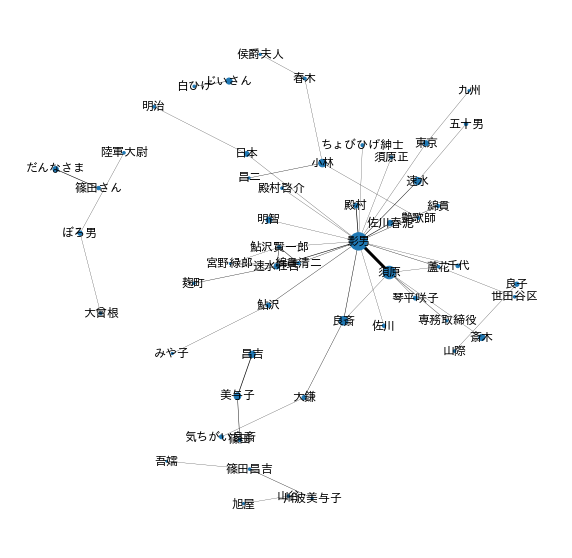

In [19]:
G = create_network(words, word_counts, Xc)
pyplot_network(G)
pyvis_G = nx2pyvis_G(G)
pyvis_G.show("mygraph.html")

In [29]:
doc = nlp("「明智小五郎っていう私立探偵知ってるでしょう？　あの人ならば、警察じゃないんだから……」")
for token in doc:
    print(token,token.pos_)

「 PUNCT
明智 PROPN
小五郎 PROPN
って ADP
いう VERB
私立 NOUN
探偵 NOUN
知っ VERB
てる AUX
でしょう AUX
？ PUNCT
　 X
あの DET
人 NOUN
なら AUX
ば SCONJ
、 PUNCT
警察 NOUN
じゃ AUX
ない ADJ
ん SCONJ
だ AUX
から SCONJ
… PUNCT
… PUNCT
」 PUNCT
